In [1]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import pandas as pd
import numpy as np
import csv
import MeCab
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import re
import neologdn
import demoji
import emoji
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()
import japanize_matplotlib

model_dir = '/Users/iomacbookair2/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
# model_dir = '/Users/labimac/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
model_word2vec = KeyedVectors.load_word2vec_format(model_dir, binary=True)
mecab = MeCab.Tagger(
    '-d /opt/homebrew/lib/mecab/dic/mecab-ipadic-neologd')


In [2]:
path = "/Users/iomacbookair2/Documents/lab/DEIM2023/experiment1/thetrad/220124_thetrad_exp1.csv"
df = pd.read_csv((path))
df.sort_values(by = 'created_at', ascending = True, inplace = True)
df = df.reset_index(drop=True)
df['created_at'] = pd.to_datetime(df['created_at'])
df

,created_at,text
0,2022-01-24 16:16:02,村治佳織さんの演奏 ハウルの曲ね❤️💗#THETRAD #稲垣吾郎 #SMAP #新しい地図
1,2022-01-24 16:16:02,中川さんのお仕事ラッドは今日が最後なのね来週からは先週、お仕事ラッドのリポートをされた安藤さ...
2,2022-01-24 16:16:12,好き人生のメリーゴーランド今朝もテレビで聞いたな…#THETRAD
3,2022-01-24 16:16:33,THE TRAD │ TOKYO FMhttps://t.co/87sJQBEkm2#rad...
4,2022-01-24 16:16:46,ハウルゥゥゥゥゥ❤️実質きむごろですね❤️💗#THETRAD にたっきゅん来ればいいのに…I...
...,...,...
450,2022-01-24 16:34:48,『夢で逢えたら』めっちゃ好きだったー！！#THETRAD
451,2022-01-24 16:34:49,森三中の村上さんがお煎餅をバリバリ吾郎店長の隣で食べてたのを見てた黒沢さん｡村上さんに注意を...
452,2022-01-24 16:34:49,夢で逢えたら面白かったねその枠に夢がMORIMORIが入ったんだよね #THETRAD
453,2022-01-24 16:34:51,懐かしー ミポリンのデビュー曲😊全然歌えるわ😁 #THETRAD


In [3]:
def preprocess(text):
    text = emoji.replace_emoji(text, replace=' ')
    text = re.sub(r'#\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'＃\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'@\S+', '', text) # @を消す
    text = re.sub(r'http?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', text) # URLをスペースに置き換え
    text = re.sub(r'https?://\S+', ' ', text) # URLをスペースに置き換え
    text = re.sub(r'!-/:-@[-`{-~]', r'', text) # 記号を消す
    text = re.sub(r'”', '', text)  # "を消す
    text = re.sub(r'"', '', text)  # "を消す
    text = re.sub(r"'", "", text) # 'を消す
    text = re.sub(r'[(`)]', '', text)
    text = re.sub(
        "[\uFF01-\uFF0F\uFF1A-\uFF20\uFF3B-\uFF40\uFF5B-\uFF65\u3000-\u303F]", '', text)  # 記号を消す
    text = re.sub(
        u'[■♯【】「」『』;・ㅂﾟˊᗜ┏━┓┗┛ヾθ、│/`:@`{-~。|∀!〇╰`′‵ˋω.*…╭∇^_￣´｀•˘д↑艸╯→°д̀ᴗ˃˂⁽⁾φ└＼※彡𖥦←ꂹ]', '', text)  # 記号を消す
    text = re.sub(r'(\d)([,.])(\d+)', r'\1\3', text) # 小数点とカンマを消す
    text = re.sub(r'\d+', '0', text) # 数字を0に置き換え
    text = text.lower() # 英字を小文字に
    text = re.sub(r"[\u3000\t\r\n]", " ", text) # 空白文字をスペースに置き換え
    text = neologdn.normalize(text)
    return text


df['text'] = df['text'].apply(preprocess)
df


,created_at,text
0,2022-01-24 16:16:02,村治佳織さんの演奏ハウルの曲ね
1,2022-01-24 16:16:02,中川さんのお仕事ラッドは今日が最後なのね来週からは先週お仕事ラッドのリポートをされた安藤さん...
2,2022-01-24 16:16:12,好き人生のメリーゴーランド今朝もテレビで聞いたな
3,2022-01-24 16:16:33,the trad tokyo fm
4,2022-01-24 16:16:46,ハウルゥゥゥゥゥ実質きむごろですねにたっきゅん来ればいいのにi˙꒳​˙
...,...,...
450,2022-01-24 16:34:48,夢で逢えたらめっちゃ好きだったー
451,2022-01-24 16:34:49,森三中の村上さんがお煎餅をバリバリ吾郎店長の隣で食べてたのを見てた黒沢さん村上さんに注意をで...
452,2022-01-24 16:34:49,夢で逢えたら面白かったねその枠に夢がmorimoriが入ったんだよね
453,2022-01-24 16:34:51,懐かしーミポリンのデビュー曲全然歌えるわ


In [4]:
# df.to_csv('preprocessed.csv', index=False)

In [5]:
import requests

url = "http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt"
r = requests.get(url)
tmp = r.text.split('\r\n')
stopwords = []
for i in range(len(tmp)):
    if len(tmp[i]) < 1:
        continue
    stopwords.append(tmp[i])

# stopwords += ["w", "ww", "www", "wwww", "wwwww", "笑",
#               "の", "し", "さ", "て", "れ", "ない", "てる",]

In [6]:
def words_list(sentence, model, mecab):
    if not sentence:
      pass
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
    #     filtered_words = [
    #         word for word in sentence_words if word not in stopwords]
    # return filtered_words
    return sentence_words


df["words"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else words_list(x, model_word2vec, mecab))
df


,created_at,text,words
0,2022-01-24 16:16:02,村治佳織さんの演奏ハウルの曲ね,"[村治佳織, さん, 演奏, ハウル, 曲]"
1,2022-01-24 16:16:02,中川さんのお仕事ラッドは今日が最後なのね来週からは先週お仕事ラッドのリポートをされた安藤さん...,"[中川, さん, お仕事, ラッド, 今日, 最後, 来週, 先週, お仕事, ラッド, リ..."
2,2022-01-24 16:16:12,好き人生のメリーゴーランド今朝もテレビで聞いたな,"[好き, 人生, メリーゴーランド, 今朝, テレビ, 聞い]"
3,2022-01-24 16:16:33,the trad tokyo fm,"[the, trad, tokyo, fm]"
4,2022-01-24 16:16:46,ハウルゥゥゥゥゥ実質きむごろですねにたっきゅん来ればいいのにi˙꒳​˙,"[ハウルゥゥゥゥゥ, 実質, きむ, ごろ, たっ, きゅん, 来れ, いい, i]"
...,...,...,...
450,2022-01-24 16:34:48,夢で逢えたらめっちゃ好きだったー,"[夢で逢えたら, めっちゃ, 好き, ー]"
451,2022-01-24 16:34:49,森三中の村上さんがお煎餅をバリバリ吾郎店長の隣で食べてたのを見てた黒沢さん村上さんに注意をで...,"[森三中, 村上, さん, お煎餅, バリバリ, 吾郎, 店長, 隣, 食べ, て, の, ..."
452,2022-01-24 16:34:49,夢で逢えたら面白かったねその枠に夢がmorimoriが入ったんだよね,"[夢で逢えたら, 面白かっ, 枠, 夢がmorimori, 入っ, ん]"
453,2022-01-24 16:34:51,懐かしーミポリンのデビュー曲全然歌えるわ,"[懐かしー, ミポリン, デビュー曲, 全然, 歌える]"


In [7]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_words = pd.DataFrame({
    "words": groups.apply(lambda x: [word for sublist in x["words"] if type(sublist) == list for word in sublist])
})
df_words = df_words.reset_index()
df_words


,created_at,words
0,2022-01-24 16:16:00,"[村治佳織, さん, 演奏, ハウル, 曲, 中川, さん, お仕事, ラッド, 今日, 最..."
1,2022-01-24 16:17:00,"[ハウルの動く城, 中川, 店員, お仕事, ラッド, 卒業, ん, 今迄, the, tr..."
2,2022-01-24 16:18:00,"[ハウルの動く城, キムタク, 声優, やっ, て, 映画, ラテン, 調, ある, 楽曲,..."
3,2022-01-24 16:19:00,"[黒沢, さん, 中川絵美里, 店員, さん, お仕事, ラッド, 卒業, 来週, 安藤咲良..."
4,2022-01-24 16:20:00,"[吉田, さん, 捧ぐ, スーパー, 筋子, 見る, 黒沢, さん, 思い出す, 吾郎, 店..."
5,2022-01-24 16:21:00,"[美味しい, 筋子, 食べ, 私, 筋子, 好き, 森三中, 黒沢かずこ, さん, 来店, ..."
6,2022-01-24 16:22:00,"[黒沢, さん, スーパー, すじこ, 見る, 黒沢, さん, 思い出す, 吾郎, 店長, ..."
7,2022-01-24 16:23:00,"[商品価格, 0円, 本日, トレンドステルスオミクロン, 気, なる, 評判, おすすめ,..."
8,2022-01-24 16:24:00,"[森三中, 0, 人, 全然, 違う, 吾郎さん, 吾郎さん, 言い, こと, たくさん, ..."
9,2022-01-24 16:25:00,"[吾郎, 店長, 相変わらず, 記憶力, 黒沢, さん, 大人, 黒沢かずこ, さん, 店長..."


In [8]:
# df_words.to_csv('words.csv', index=False)

In [9]:
def save_wordclowd(words, index):
    if len(words) == 0:
        plt.axis("off")
    else:
        wordcloud = WordCloud(background_color="white", width=600, height=400, min_font_size=15,
                              font_path='/Users/iomacbookair2/Library/Fonts/IBMPlexSansJP-Regular.otf').generate(' '.join(words))
        plt.axis("off")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.savefig(f"{index+1}.png")
    plt.clf()


df_words.apply(lambda x: save_wordclowd(x["words"], x.name), axis=1)


0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
dtype: object

<Figure size 640x480 with 0 Axes>

In [10]:
def word_to_vec(sentence, model, mecab):
    if not sentence:
        sentence_embedding = np.zeros(200, dtype=np.float32)
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
                # if parts[1].startswith("名詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("動詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("形容詞"):
                #     sentence_words.append(features[6])
        # print(sentence_words)
        if all(re.match(r'.*[a-zA-Z].*', word) for word in sentence_words):
            sentence_embedding = np.zeros(200, dtype=np.float32)
        else:
            word_vectors = [model[word]
                            for word in sentence_words if word in model]
            if word_vectors:
                if len(word_vectors) == 0:
                    sentence_embedding = np.zeros(200, dtype=np.float32)
                else:
                    sentence_embedding = np.mean(word_vectors, axis=0)
            else:
                sentence_embedding = np.zeros(200, dtype=np.float32)
    return sentence_embedding

df["vector"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else word_to_vec(x, model_word2vec, mecab))
df = df.drop("text", axis=1)
df = df.drop("words", axis=1)
df


,created_at,vector
0,2022-01-24 16:16:02,"[-2.0835056, -0.3124367, -0.19678849, 0.912503..."
1,2022-01-24 16:16:02,"[-0.06139237, 0.68736917, -0.07654676, 0.13848..."
2,2022-01-24 16:16:12,"[0.03942296, -0.8291156, -0.83459514, -0.62037..."
3,2022-01-24 16:16:33,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2022-01-24 16:16:46,"[-0.52515125, -0.19474883, 0.33392957, 0.37631..."
...,...,...
450,2022-01-24 16:34:48,"[-0.41559374, -1.7440134, 0.21608551, 0.006099..."
451,2022-01-24 16:34:49,"[-0.5707299, 0.3201651, 0.15237705, -0.7331496..."
452,2022-01-24 16:34:49,"[0.93823063, 0.33407128, -0.14122944, 1.245652..."
453,2022-01-24 16:34:51,"[-0.54012394, -0.01383559, -0.043221697, 0.625..."


In [11]:
# df.to_csv('vector.csv', index=False)

In [12]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_vectors = pd.DataFrame({
    "vectors": groups.apply(lambda x: x["vector"].tolist())
})
df_vectors = df_vectors.reset_index()
df_vectors


,created_at,vectors
0,2022-01-24 16:16:00,"[[-2.0835056, -0.3124367, -0.19678849, 0.91250..."
1,2022-01-24 16:17:00,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,2022-01-24 16:18:00,"[[-0.7219531, 0.23060967, -0.5437979, -0.77453..."
3,2022-01-24 16:19:00,"[[-0.56508857, 1.1167865, 1.0401875, -0.237444..."
4,2022-01-24 16:20:00,"[[-0.500843, 0.8249378, 0.8123255, 0.05533372,..."
5,2022-01-24 16:21:00,"[[-0.9178587, -1.2325305, 0.009703919, -0.7043..."
6,2022-01-24 16:22:00,"[[-0.56508857, 1.1167865, 1.0401875, -0.237444..."
7,2022-01-24 16:23:00,"[[-0.25270134, -0.37303275, -0.19502196, -0.40..."
8,2022-01-24 16:24:00,"[[-0.41544333, 0.12660079, -0.6105453, -0.4671..."
9,2022-01-24 16:25:00,"[[-0.79509336, -0.14043307, 0.10156693, -0.044..."


In [13]:
def calc_similarity(vector1, vector2):
  similarity = cosine_similarity(vector1, vector2)[0][0]
  return similarity


def calc_average_similarity(vectors, key):
    similarities = []
    for i in range(len(vectors)):
        for j in range(i + 1, len(vectors)):
            if np.all(vectors[i] == 0) or np.all(vectors[j] == 0):
                continue
            else:
                similarity = calc_similarity(vectors[i].reshape(1, -1), vectors[j].reshape(1, -1))
            similarities.append(similarity)
    q = [0, 0.25, 0.5, 0.75, 1]
    outputs = {}
    for i in range(len(q)):
        outputs[f"q{i}"] = np.quantile(similarities, q[i])
    outputs["standard_deviation"] = np.std(similarities)
    outputs["mean"] = np.mean(similarities)
    if key == "q2":
        return outputs["q2"]
    elif key == "q1":
        return outputs["q1"]
    elif key == "q3":
        return outputs["q3"]
    elif key == "standard_deviation":
        return outputs["standard_deviation"]
    elif key == "mean":
        return outputs["mean"]


In [14]:
df_vectors["q1"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q1"))
df_vectors["q2"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q2"))
df_vectors["q3"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q3"))
df_vectors["mean"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "mean"))
df_vectors["stdev"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "standard_deviation"))
df_vectors = df_vectors.drop("vectors", axis=1)
df_vectors


,created_at,q1,q2,q3,mean,stdev
0,2022-01-24 16:16:00,0.253102,0.368601,0.454579,0.359390,0.121562
1,2022-01-24 16:17:00,0.641420,0.641420,0.641420,0.641420,0.000000
2,2022-01-24 16:18:00,0.357207,0.357207,0.357207,0.357207,0.000000
3,2022-01-24 16:19:00,0.314848,0.576979,0.639869,0.540538,0.209211
4,2022-01-24 16:20:00,0.221222,0.474501,0.671804,0.460494,0.250278
5,2022-01-24 16:21:00,0.342509,0.475935,0.618918,0.491038,0.187599
6,2022-01-24 16:22:00,0.301624,0.511501,0.667123,0.488608,0.224294
7,2022-01-24 16:23:00,0.411501,0.579878,0.673035,0.525437,0.209208
8,2022-01-24 16:24:00,0.363976,0.521749,0.660218,0.499504,0.198843
9,2022-01-24 16:25:00,0.408825,0.496790,0.562202,0.491587,0.125249


In [15]:
df_vectors.to_csv('similarity.csv', index=False)


In [16]:
path_count = "/Users/iomacbookair2/Documents/lab/DEIM2023/experiment1/thetrad/count_exp1.csv"
df_count = pd.read_csv((path_count))
df_vectors["tweet"] = df_count["tweet"]
df_vectors['created_at'] = df_vectors['created_at'].astype(str)
start_time = df_vectors['created_at'].min()
start_time = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: (
    datetime.strptime(x, '%Y-%m-%d %H:%M:%S') - start_time).total_seconds() / 60+1)
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: round(x))
df_vectors


,created_at,q1,q2,q3,mean,stdev,tweet
0,1,0.253102,0.368601,0.454579,0.359390,0.121562,5
1,2,0.641420,0.641420,0.641420,0.641420,0.000000,3
2,3,0.357207,0.357207,0.357207,0.357207,0.000000,2
3,4,0.314848,0.576979,0.639869,0.540538,0.209211,7
4,5,0.221222,0.474501,0.671804,0.460494,0.250278,18
5,6,0.342509,0.475935,0.618918,0.491038,0.187599,20
6,7,0.301624,0.511501,0.667123,0.488608,0.224294,31
7,8,0.411501,0.579878,0.673035,0.525437,0.209208,37
8,9,0.363976,0.521749,0.660218,0.499504,0.198843,32
9,10,0.408825,0.496790,0.562202,0.491587,0.125249,30


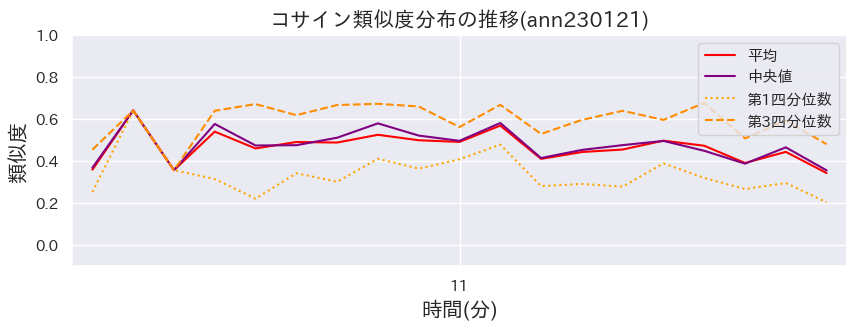

In [17]:
window_sizes = [1]
for window in window_sizes:
    df_vectors['q1'] = df_vectors['q1'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q2'] = df_vectors['q2'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q3'] = df_vectors['q3'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.set_title(
        "コサイン類似度分布の推移(ann230121)", fontsize=15)
    indices = range(0, len(df_vectors), 10)
    plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows+0.5)
    ax.set_ylim(-0.1, 1)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("類似度", fontsize=15)
    ax.plot(df_vectors["created_at"], df_vectors["mean"], color="red",
            label="平均")
    ax.plot(df_vectors["created_at"], df_vectors["q2"], color="purple",
            label="中央値")
    ax.plot(df_vectors["created_at"], df_vectors["q1"], color="orange", linestyle="dotted",
            label="第1四分位数")
    ax.plot(df_vectors["created_at"], df_vectors["q3"], color="darkorange", linestyle="dashed",
            label="第3四分位数")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    plt.savefig('quantile.png')


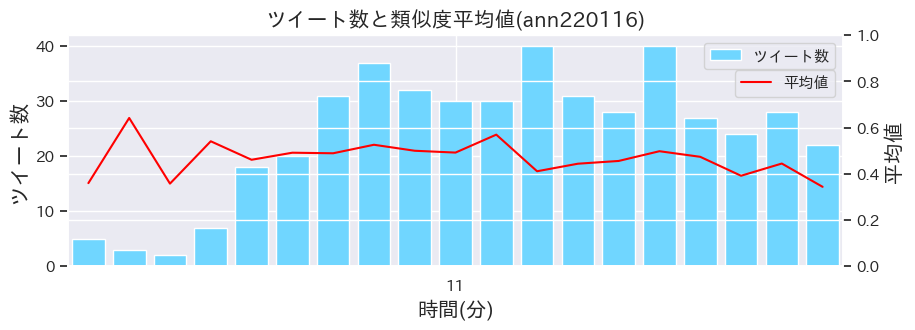

In [18]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    # df_vectors['stdev'] = df_vectors['stdev'].rolling(
    #     window=window, min_periods=1).mean()
    # df_vectors['alpha_m'] = df_vectors['mean'] - df_vectors['stdev']
    # df_vectors['alpha_p'] = df_vectors['mean'] + df_vectors['stdev']

    fig, ax = plt.subplots(figsize=(10, 3))
    ax.set_title(
        "ツイート数と類似度平均値(ann220116)", fontsize=15)
    indices = range(0, len(df_vectors), 10)
    plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows + 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("平均値", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["mean"], color="red", label="平均値")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_m"], color="orange", linestyle="dashed")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_p"], color="orange", linestyle="dashed",label="68%信頼区間")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.88))
    plt.savefig('mean.png')


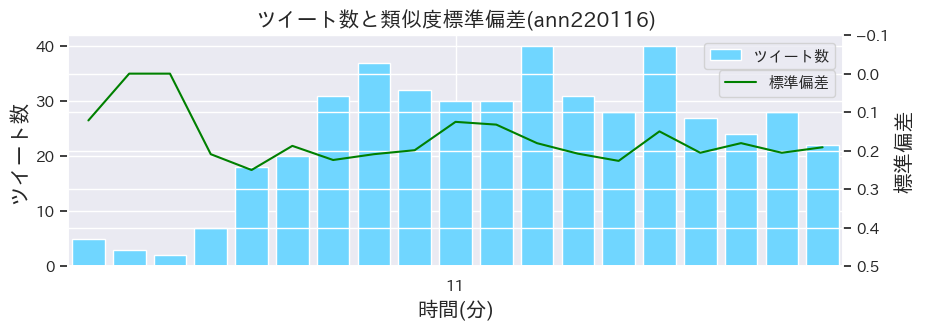

In [19]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['stdev'] = df_vectors['stdev'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.set_title(
        "ツイート数と類似度標準偏差(ann220116)", fontsize=15)
    indices = range(0, len(df_vectors), 10)
    plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows + 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0.5, -0.1)
    ax2.set_ylabel("標準偏差", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["stdev"], color="green",
             label="標準偏差")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.88))
    plt.savefig('stdev.png')
